In [1]:
## parameters for experiment
N_BLOCK = 5
#LR = 0.00001
LR = 0.001

OUTPUT_DIR = '20251020-MCU-Net-CombinedLoss-CombinedLossv2'

RANDOM_SEED = 42

IN_CHANNEL = 1

AUGMENTED = True
AUGMENTATION  =  30


CROSS_VAL = True
N_SPLIT = 4


#optimization constants
DICE_IMPORTANCE = 1.0
CE_IMPORTANCE = 1.0

In [2]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-10-21 16:04:50.393328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 16:04:51.114053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [4]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251020-MCU-Net-CombinedLoss-CombinedLossv2
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2


In [7]:
## feature list definition
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

# inputfeature_list = ["GRY_", "NML1", "NML2", "NML3", "NML1", "MEA1",
#                      "MEA2", "MED1", "MED2", "NML1", "NGP_", "KNN1",
#                      "KNN2", "BLT1", "BLT2", "UNS1", "UNS2", "UNS3",
#                      "UNS4", "UNS5", "ERO1", "ERO2", "ERO3", "ERO4",
#                      "ERO5", "ERO6", "OPN1", "OPN2", "OPN3", "OPN4",
#                      "OPN5", "CLO1", "CLO2", "CLO3", "CLO4", "CLO5",
#                      "MIN1", "MIN2", "MIN3", "MIN4", "MAX1", "MAX2",
#                      "MAX3", "MAX4", "MRL1", "MRL2", "MRL3", "MRL4",
#                      "RIC_",
#                      ]



# unet only
#inputfeature_list = inputfeature_list[:1]

#inputfeature_list.clear()

#inputfeature_list.append("RIC_")
#print(inputfeature_list)

#inputfeature_list.remove(OUTPUT_DIR[-4:])
# inputfeature_list.remove("TOP1")
# inputfeature_list.remove("TOP2")
# inputfeature_list.remove("TOP3")
# inputfeature_list.remove("TOP4")

# inputfeature_list.remove("SBLX")
# inputfeature_list.remove("SBLY")
# inputfeature_list.remove("SBLM")
# inputfeature_list.remove("SBLD")
# inputfeature_list.remove("SBL1")
# inputfeature_list.remove("SBL2")
# inputfeature_list.remove("SBL3")
# inputfeature_list.remove("SBL4")

# inputfeature_list.remove("LPL1")
# inputfeature_list.remove("LPL2")

# inputfeature_list.remove("LBP1")
# inputfeature_list.remove("LBP2")
# inputfeature_list.remove("LBP3")

# inputfeature_list.remove("SOL_")
# inputfeature_list.remove("OOO_")

# inputfeature_list.remove("CAN1")
# inputfeature_list.remove("CAN2")
# inputfeature_list.remove("CAN3")


# inputfeature_list.remove("FOU1")
# inputfeature_list.remove("FOU2")
# inputfeature_list.remove("FOU3")
# inputfeature_list.remove("FOU4")

# inputfeature_list.remove("SCH1")
# inputfeature_list.remove("SCH2")
# inputfeature_list.remove("SCH3")
# inputfeature_list.remove("SCH4")

# inputfeature_list.remove("ROB1")
# inputfeature_list.remove("ROB2")
# inputfeature_list.remove("ROB3")
# inputfeature_list.remove("ROB4")

# inputfeature_list.remove("MRG1")
# inputfeature_list.remove("MRG2")
# inputfeature_list.remove("MRG3")
# inputfeature_list.remove("MRG4")

# inputfeature_list.remove("BTM1")
# inputfeature_list.remove("BTM2")
# inputfeature_list.remove("BTM3")
# inputfeature_list.remove("BTM4")

# inputfeature_list.remove("DST_")
# inputfeature_list.remove("HOM_")

# for i in range(108):
#     stckd_feature_name = "NGP_" + inputfeature_list[i]
#     inputfeature_list.append(stckd_feature_name)

# for input_feature in inputfeature_list[:]:
#     if not input_feature.startswith("NGP"):
#         inputfeature_list.remove(input_feature)
        


print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [8]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, label_dataset


In [9]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [10]:
## create weight test example

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
## createweightimageforshow
# # # 重みを基づいて、MC画像を生成する
# # # function for showing MC image
# # # gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [12]:
## value extraction for visual mc
# # ## Netron app to extract the weight tensor
# # ## if the conv is 1x1 the tensor has 45 values
# # ## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
# def compute_mean_values(input_list):
#     """
#     Compute mean of 3x3 blocks in each channel of the input list.
    
#     Args:
#         input_list (list): A 4D list of shape (1, C, H, W).
        
#     Returns:
#         list: A 1D list of length C containing the mean values for each channel.
#     """
#     # Ensure the input is a 4D list
#     if not isinstance(input_list, list) or len(input_list) != 1:
#         raise ValueError("Expected input list of shape (1, C, H, W)")
    
#     channels = input_list[0]  # Get the channels (C, H, W)
    
#     if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
#         raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
#     mean_values = []
#     for channel in channels:
#         if not all(isinstance(row, list) for row in channel):
#             raise ValueError("Each channel must contain 2D lists.")
        
#         # Flatten the 2D channel to compute the mean
#         flattened = [value for row in channel for value in row]
#         mean_values.append(sum(flattened) / len(flattened))
    
#     return mean_values


In [13]:
## mc image visualization example
# ### 1X1-1029-23-n1-1
# ### JUST SINGLE VARIATION
# weight_tensor_1x1_1029_23_n1_1_example = [
#     [
#         [
#             [
#                 0.048620592802762985
#                 ...
#     ]
# ]

# input_number = ['N1-1']

# #single
# weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

# weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
# weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
# weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
# weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
# weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

# print(len(weight_cn))
# print(len(weight_cn1))
# print(len(weight_cn2))
# print(len(weight_cn3))
# print(len(weight_cn4))
# print(len(weight_cn5))

# CreateWeightImageforShow(weight_cn, input_number, "single")

# CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
# CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
# CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
# CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
# CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



In [14]:
## mc image visualization example
# weight_tensor = np.load("/home/eric/Documents/cervicalResearchIIP/result_test/20250420-MCU-Net-108/0420_MCU108_fold4_w.npy")

# # initial shape (3, 108, 3, 3) (out_channels, channels, height_convolution, width_convolution)
# # np.mean takes mean value of out_channels
# # [np.newaxis, :] shapes into (1, 108, 3, 3)
# weight_tensor = np.mean(weight_tensor, axis = 0)[np.newaxis, :]
# weight_tensor = weight_tensor.tolist()

# #f1
# #input_number = ["N1-1", "N1-7", "N1-9", "N2-3", "N2-7", "N2-10", "N3-1", "N3-8", "N3-10", "N4-8", "N5-4"]
# #f2
# #input_number = ["N1-2", "N1-5", "N1-10", "N2-4", "N3-2", "N3-4", "N3-5", "N3-9", "N4-3", "N4-9", "N5-2"]
# #f3
# #input_number = ["N1-3", "N1-4", "N1-10", "N2-1", "N2-5", "N2-8", "N3-3", "N3-7", "N4-4", "N4-5", "N4-6", "N5-1", "N5-6"]
# #f4
# input_number = ["N1-6", "N1-8", "N2-2", "N2-6", "N2-9", "N3-6", "N4-1", "N4-2", "N4-7", "N5-3", "N5-5"]

# # weight_tensor_converted = weight_tensor[0].tolist()

# # weight_tensor_dv1 = [weight_tensor_converted]
# # # print(weight_tensor_dv1.shape)
# weight_cn  = compute_mean_values(weight_tensor)

# CreateWeightImageforShow(weight_cn, input_number, "fold4")

In [15]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [16]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    #for direct loading
    dataset_train2 = SegmentationDataSet0(
                                        #inputs=dataset_original,
                                        inputs=input_dataset,
                                        targets=label_dataset,
                                        transform=transforms_training)
    # for lazy loading
    # dataset_train2 = SegmentationDataSet5(
    #                                     #inputs=dataset_original,
    #                                     feature_paths=input_dataset,
    #                                     label_paths=label_dataset,
    #                                     feature_num = IN_CHANNEL,
    #                                     transform=transforms_training)

    # dataloader training
    #rearranged in custom order so shuffle is false in normal case: true
    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                     batch_size = 2,
                                     shuffle=True)
                                     #num_workers=4,
                                     #pin_memory=True)
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
                                        targets=label_dataset_val,
                                        transform=transforms_val)
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 2,
                                     shuffle=False)
                                     #num_workers=4, # for faster training loads next batch while training
                                     #pin_memory=True)  # for faster training, keeps data in pinned memory
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    from customLoss import BoundaryDiceLoss

    from customLoss import BoundaryIOU
    from customLoss import FocalLoss
    from customLoss import CombinedLossV2
    
    #criterion = FocalLoss()
    
    
    criterion = CombinedLossV2()
    criterion.to(device=device)

    #loss function
    #criterion = ConfusionPenaltyLoss(num_classes=11)
    # pytorch cross entropy loss function
    
    #criterion = torch.nn.CrossEntropyLoss(ignore_index = 0)
    
    #criterion = EnsembleInspiredLoss()
    
    #custom dice loss
    #criterion = DiceLoss()
    
    #custom combination loss of dice and cross entropy
    # 40 60 ratio
    #criterion = DiceCELoss(dice_weight = DICE_IMPORTANCE, ce_weight = CE_IMPORTANCE)
    
    # pytorch bce loss 
    # criterion = BCEWithLogitsLoss()
    
    # custom combination log exp loss of dice and cross entropy
    # requires segmentation class number
    #criterion = ExponentialLogCE_DiceLoss(num_class = 11)

    #optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-7)
    
    #Your case (instability)1e-4 or 3e-4
    # #Small dataset1e-4
    # Large dataset3e-4 to 1e-3
    # Transfer learning1e-5 to 1e-4
    # Training from scratch3e-4
    # Loss oscillating/spikingReduce current LR by 10x
    # oss not decreasingIncrease LR or check other issues
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    
    # start training
    training_losses, validation_losses, lr_rates, learning_curve, weights_lossf = trainer.run_trainer()
    
    #logging to csv
    assert len(training_losses) == len(validation_losses) == len(lr_rates), \
        "Lengths of training, validation losses, and learning rates must match."

    # Create dataframe
    df = pd.DataFrame({
        "Epoch": list(range(1, len(training_losses) + 1)),
        "Training_Loss": training_losses,
        "Validation_Loss": validation_losses,
        "Learning_Rate": lr_rates
    })

    # Save to CSV
    df.to_csv(test_result_dir + f"/fold{fold}_log.csv", index = False)
    
    learning_curve.savefig(test_result_dir + f"/fold{fold}_learningcurve.png")
    weights_lossf.savefig(test_result_dir + f"/fold{fold}_weights_lossf.png")
    
    print("***************************")

    
    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [18]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [19]:

## mConv_predict test function
import statistics
from denseCRF import noiseReduction
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        print("Using CPU instead of GPU")
        torch.device('cpu')

    model = UNet(in_channels=IN_CHANNEL,  # check the parameters
                out_channels=11,
                n_blocks=N_BLOCK,
                start_filters=32,
                activation='relu',
                normalization='instance', #use instance when "batch" size is less than 10? batch
                conv_mode='same',
                dim=2).to(device)

    model_dir = os.path.join("model", date_str)
    print("model_dir = ", model_dir)
    model_path = os.path.join(model_dir, f"model_fold_{fold}.pt") # load the model
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)

    model.eval()

    # create test dataset
    test_input_dataset, _ = CreateWeightImage(test_input_name)
 

    # convert to torch
    test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)


    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict
    output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


    plot_output_img = list()
    
    
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # save images
    for i, output_img in enumerate(output):
        #for checking the unique values of the result label
        labels = np.unique(output_img)

        output_image_path = os.path.join(fold_dir, f"{test_input_name[i]}.png")
        cv2.imwrite(output_image_path, output_img)
        
        # old writing when there was no stratifiedkfold
        # cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

        #print(labels)
        plot_output_img.append(output_img)


    Dice = cal_DiceMulitple(fold_dir, test_input_name)
    df = pd.DataFrame(Dice)
    df = df.T
    df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    
    postCRF = noiseReduction(output, test_input_name, labeled_dir, fold_dir, 0.8)
    
    DiceCRF = cal_DiceMulitple( fold_dir + "/crf", test_input_name)
    dfCRF = pd.DataFrame(DiceCRF)
    dfCRF = dfCRF.T
    dfCRF.to_csv(test_result_dir + "/CRFDice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    

    



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Number of label images: 660
Completed creating image arrays:
Dataset shape  (660, 256, 256, 1)
Label image shape  (660, 256, 256)

Creating image arrays...
Number of label images: 330
Completed creating image arrays:
Dataset shape  (330, 256, 256, 1)
Label image shape  (330, 256, 256)

*************************Training*************************
x.shape =  torch.Size([2, 1, 256, 256])
x.min(), x.max() =  tensor(0.) tensor(1.)
y.shape =  torch.Size([2, 256, 256])
torch.unique(y) =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
in constructor inchannel: 1
Input channel count10
=======start training======


Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 1.1578806725415316
val_losses 0.9703648307106711
lr 0.0001
Validation loss decreased (inf --> 0.970365).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.8256324164795154
val_losses 0.7695105762192698
lr 0.0001017999999999998
Validation loss decreased (0.970365 --> 0.769511).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.6453220882199028
val_losses 0.6739179795438593
lr 0.00010360000000000001
Validation loss decreased (0.769511 --> 0.673918).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.5386195946823467
val_losses 0.6107273858605009
lr 0.00010539999999999981
Validation loss decreased (0.673918 --> 0.610727).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.4757627192771796
val_losses 0.5801199020761432
lr 0.00010720000000000002
Validation loss decreased (0.610727 --> 0.580120).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.43054329346526754
val_losses 0.5521687449830951
lr 0.00010899999999999982
Validation loss decreased (0.580120 --> 0.552169).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.39060208183346373
val_losses 0.5214036856636857
lr 0.00011080000000000001
Validation loss decreased (0.552169 --> 0.521404).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.34602721134821574
val_losses 0.4837029094045812
lr 0.00011259999999999981
Validation loss decreased (0.521404 --> 0.483703).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.2761862259471055
val_losses 0.43836526798479486
lr 0.00011440000000000002
Validation loss decreased (0.483703 --> 0.438365).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.20614429077867305
val_losses 0.3837430154735392
lr 0.00011619999999999982
Validation loss decreased (0.438365 --> 0.383743).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.15565253200404572
val_losses 0.3428173129305695
lr 0.00011800000000000002
Validation loss decreased (0.383743 --> 0.342817).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.12343733389720772
val_losses 0.33541159241488483
lr 0.00011979999999999982
Validation loss decreased (0.342817 --> 0.335412).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10203315035411806
val_losses 0.3306538619778373
lr 0.00012160000000000003
Validation loss decreased (0.335412 --> 0.330654).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08929749551144513
val_losses 0.32419238749778634
lr 0.00012339999999999983
Validation loss decreased (0.330654 --> 0.324192).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0803298502821814
val_losses 0.31124881677555316
lr 0.00012520000000000003
Validation loss decreased (0.324192 --> 0.311249).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.07426799733304616
val_losses 0.3156592615626075
lr 0.00012699999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06966231815291174
val_losses 0.3221308137431289
lr 0.00012880000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06943002943739747
val_losses 0.31014194587866467
lr 0.00013059999999999984
Validation loss decreased (0.311249 --> 0.310142).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0634752999878291
val_losses 0.30989282284722186
lr 0.00013240000000000002
Validation loss decreased (0.310142 --> 0.309893).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.060864374696305304
val_losses 0.31524953056465493
lr 0.00013419999999999985
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05830940539863977
val_losses 0.32292382979031764
lr 0.00013600000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05690770875098127
val_losses 0.3165210516163797
lr 0.00013779999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0549544641127189
val_losses 0.32276034300977535
lr 0.00013960000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05319910601458766
val_losses 0.3264656853495222
lr 0.00014139999999999983
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.051997663848327866
val_losses 0.3157629413135124
lr 0.00014320000000000004
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.050713740785916644
val_losses 0.31841631360126266
lr 0.00014499999999999984
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0486515701945984
val_losses 0.332221622448979
lr 0.00014680000000000004
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04806096915042762
val_losses 0.3266922901977192
lr 0.00014859999999999984
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04660972544189655
val_losses 0.32644214187607623
lr 0.00015040000000000005
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04562080400911245
val_losses 0.33133191366990405
lr 0.00015219999999999985
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.044385108024333465
val_losses 0.3316211045691461
lr 0.00015400000000000006
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.044197931343858896
val_losses 0.32715381736105137
lr 0.00015579999999999986
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04657354600953333
val_losses 0.31338730933088244
lr 0.00015760000000000006
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04259592905414827
val_losses 0.323683285984126
lr 0.00015939999999999986
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.041175687685608864
val_losses 0.3345104477622292
lr 0.00016120000000000007
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.040931237037434724
val_losses 0.3276345274665139
lr 0.00016299999999999984
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.040556825725643925
val_losses 0.3238109934510607
lr 0.00016480000000000005
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.038975667270521326
val_losses 0.3346737127412449
lr 0.00016659999999999988
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03823596893837958
val_losses 0.33345836608698876
lr 0.00016840000000000008
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03797501120151896
val_losses 0.33209866140827987
lr 0.00017019999999999985
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03756102233222037
val_losses 0.33513524712938253
lr 0.00017200000000000006
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.036572433754124424
val_losses 0.331481812487949
lr 0.0001737999999999999
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04505892224948515
val_losses 0.3329118467641599
lr 0.00017560000000000007
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04302036283594189
val_losses 0.3209296265334794
lr 0.00017739999999999987
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03489962654809157
val_losses 0.3256301755254919
lr 0.00017920000000000007
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03303530965226166
val_losses 0.3389723073352467
lr 0.00018099999999999987
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.032886241901327266
val_losses 0.32613618753173135
lr 0.00018280000000000008
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03261734668842771
val_losses 0.3339438697605422
lr 0.00018459999999999988
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.032597834142771634
val_losses 0.3571722273573731
lr 0.00018640000000000009
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03223895501684059
val_losses 0.3396799129970146
lr 0.00018819999999999989
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.032316738993606785
val_losses 0.3568435648173997
lr 0.00019000000000000006
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03241507736683795
val_losses 0.3374505691456072
lr 0.0001917999999999999
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03142848444933241
val_losses 0.34107454211422894
lr 0.0001936000000000001
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.030716382458128712
val_losses 0.3378730019836715
lr 0.00019539999999999987
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03062083793408943
val_losses 0.3415561873804439
lr 0.00019720000000000008
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03088625046339902
val_losses 0.34119357547976753
lr 0.0001989999999999999
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.03052333113031857
val_losses 0.3478279007203651
lr 0.0002008000000000001
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.029747115899667595
val_losses 0.3498448902910406
lr 0.00020259999999999988
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.028991965464118755
val_losses 0.3635056526371927
lr 0.0002044000000000001
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.028617437161279447
val_losses 0.3639297553084113
lr 0.00020619999999999992
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.029506821710277686
val_losses 0.36164895648306067
lr 0.0002080000000000001
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02796318878730138
val_losses 0.3665290423414924
lr 0.0002097999999999999
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.027643875122973414
val_losses 0.3634980169209567
lr 0.0002116000000000001
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02745562685710011
val_losses 0.363292342785633
lr 0.0002133999999999999
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.027487558532844892
val_losses 0.36475197022611444
lr 0.0002152000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.026881051594109247
val_losses 0.3573666662880869
lr 0.0002169999999999999
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.026765119848829327
val_losses 0.35323251991560967
lr 0.00021880000000000011
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02654259011826732
val_losses 0.3706575536366665
lr 0.00022059999999999991
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02721036666383346
val_losses 0.35511072928255255
lr 0.0002224000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 68
***************************
modelname:model_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251020-MCU-Net-CombinedLoss-CombinedLossv2
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold1/N1-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-4.png
index =  2
予測画像: /home/eric/Doc

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.1657653118624831
val_losses 1.0989300502671135
lr 0.0001
Validation loss decreased (inf --> 1.098930).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.9109697730252238
val_losses 0.895591805709733
lr 0.0001017999999999998
Validation loss decreased (1.098930 --> 0.895592).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.7061934545184627
val_losses 0.7669607069757249
lr 0.00010360000000000001
Validation loss decreased (0.895592 --> 0.766961).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5823660883939628
val_losses 0.7071367813481225
lr 0.00010539999999999981
Validation loss decreased (0.766961 --> 0.707137).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5088201424389175
val_losses 0.6876436832878324
lr 0.00010720000000000002
Validation loss decreased (0.707137 --> 0.687644).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4562055344834472
val_losses 0.6813189405534003
lr 0.00010899999999999982
Validation loss decreased (0.687644 --> 0.681319).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4151936720718037
val_losses 0.6628852620720863
lr 0.00011080000000000001
Validation loss decreased (0.681319 --> 0.662885).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3677481296387586
val_losses 0.6230608243081305
lr 0.00011259999999999981
Validation loss decreased (0.662885 --> 0.623061).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.29647909159010105
val_losses 0.6039929817120234
lr 0.00011440000000000002
Validation loss decreased (0.623061 --> 0.603993).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.21479238870017456
val_losses 0.5136595071189933
lr 0.00011619999999999982
Validation loss decreased (0.603993 --> 0.513660).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.14944453639062968
val_losses 0.5094320798913637
lr 0.00011800000000000002
Validation loss decreased (0.513660 --> 0.509432).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.12336126644954537
val_losses 0.49025371430648695
lr 0.00011979999999999982
Validation loss decreased (0.509432 --> 0.490254).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10745079282558326
val_losses 0.4942036412656307
lr 0.00012160000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09340230876749211
val_losses 0.48107423277364836
lr 0.00012339999999999983
Validation loss decreased (0.490254 --> 0.481074).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08434622919920719
val_losses 0.47404212976495425
lr 0.00012520000000000003
Validation loss decreased (0.481074 --> 0.474042).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08090018914504485
val_losses 0.4856382275621096
lr 0.00012699999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07897053814747117
val_losses 0.4794683197306262
lr 0.00012880000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07486911388960751
val_losses 0.5058152039845785
lr 0.00013059999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07272104289044033
val_losses 0.5048624959256914
lr 0.00013240000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06687327508221973
val_losses 0.49626389683948624
lr 0.00013419999999999985
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06422384642064571
val_losses 0.5032692741188738
lr 0.00013600000000000003
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06379905450298931
val_losses 0.5058581847283575
lr 0.00013779999999999983
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06010157473836884
val_losses 0.5025517448782921
lr 0.00013960000000000003
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.062264190128806865
val_losses 0.4870013604561488
lr 0.00014139999999999983
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05747019825785449
val_losses 0.5204068104426066
lr 0.00014320000000000004
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05538167617086208
val_losses 0.5023060167001353
lr 0.00014499999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05506185261589108
val_losses 0.5318137673040231
lr 0.00014680000000000004
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05339706513014707
val_losses 0.511046549015575
lr 0.00014859999999999984
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.052352502513112444
val_losses 0.5078380867011018
lr 0.00015040000000000005
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05264074519050844
val_losses 0.5268281042575836
lr 0.00015219999999999985
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05551715597058787
val_losses 0.5230411470764214
lr 0.00015400000000000006
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04923604714373748
val_losses 0.5191327716741297
lr 0.00015579999999999986
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04788406264375557
val_losses 0.5266018319461081
lr 0.00015760000000000006
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.047285703005212724
val_losses 0.5628829138974348
lr 0.00015939999999999986
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04614317122508179
val_losses 0.5435973909166124
lr 0.00016120000000000007
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04603083261260481
val_losses 0.5426233785847823
lr 0.00016299999999999984
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04607574376418735
val_losses 0.5337553246153726
lr 0.00016480000000000005
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.044055848715431764
val_losses 0.5250630634526412
lr 0.00016659999999999988
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.045027806903376724
val_losses 0.5893241383963161
lr 0.00016840000000000008
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05254341181028973
val_losses 0.5378125621212854
lr 0.00017019999999999985
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04254801239479672
val_losses 0.5390367171002759
lr 0.00017200000000000006
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04103390902958133
val_losses 0.5273716121912002
lr 0.0001737999999999999
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0401217148554596
val_losses 0.5394762108723322
lr 0.00017560000000000007
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03976654425602068
val_losses 0.5366636103226079
lr 0.00017739999999999987
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03982742673745661
val_losses 0.5579683998392688
lr 0.00017920000000000007
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03974057016047564
val_losses 0.5764088655511538
lr 0.00018099999999999987
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.038818916051902554
val_losses 0.5553086678187052
lr 0.00018280000000000008
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.037819179678053566
val_losses 0.5470106769767072
lr 0.00018459999999999988
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.040919918177480044
val_losses 0.5711470580763287
lr 0.00018640000000000009
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04505421852862293
val_losses 0.5100871389938726
lr 0.00018819999999999989
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03674070844144532
val_losses 0.5314767179389794
lr 0.00019000000000000006
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03488205862090443
val_losses 0.5423379725880093
lr 0.0001917999999999999
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03428117406526298
val_losses 0.542533541470766
lr 0.0001936000000000001
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03468575155870481
val_losses 0.5285269544356399
lr 0.00019539999999999987
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03446646918627349
val_losses 0.5483504720860057
lr 0.00019720000000000008
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03428153721897891
val_losses 0.5339972496032714
lr 0.0001989999999999999
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033300918097974676
val_losses 0.5742107533746296
lr 0.0002008000000000001
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033431263629234195
val_losses 0.570496435628997
lr 0.00020259999999999988
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033061251303914824
val_losses 0.5626088118387593
lr 0.0002044000000000001
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.032883518008571685
val_losses 0.535576993972063
lr 0.00020619999999999992
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03233481559789542
val_losses 0.563113688511981
lr 0.0002080000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03230078325352886
val_losses 0.550976818220483
lr 0.0002097999999999999
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.031770491255729484
val_losses 0.5624661143455241
lr 0.0002116000000000001
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03127636717011531
val_losses 0.55815128510197
lr 0.0002133999999999999
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0308876578724294
val_losses 0.5574935375816292
lr 0.0002152000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 64
***************************
modelname:model_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251020-MCU-Net-CombinedLoss-CombinedLossv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold2/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold2/N1-8.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-8.png
index =  2
予測画像: /home/eric/Docum

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.023166754209634
val_losses 0.893050534857644
lr 0.0001
Validation loss decreased (inf --> 0.893051).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.7691141921462434
val_losses 0.7262452337476942
lr 0.0001017999999999998
Validation loss decreased (0.893051 --> 0.726245).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.6073456518577807
val_losses 0.6547598229514228
lr 0.00010360000000000001
Validation loss decreased (0.726245 --> 0.654760).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5270114360433636
val_losses 0.6056804961628384
lr 0.00010539999999999981
Validation loss decreased (0.654760 --> 0.605680).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4740054681445613
val_losses 0.5777956591712103
lr 0.00010720000000000002
Validation loss decreased (0.605680 --> 0.577796).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.42841244538625084
val_losses 0.5470554755793677
lr 0.00010899999999999982
Validation loss decreased (0.577796 --> 0.547055).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3831908503265092
val_losses 0.5347671742240588
lr 0.00011080000000000001
Validation loss decreased (0.547055 --> 0.534767).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3111863999204202
val_losses 0.4559679079386923
lr 0.00011259999999999981
Validation loss decreased (0.534767 --> 0.455968).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.2265120995767189
val_losses 0.41896457026402156
lr 0.00011440000000000002
Validation loss decreased (0.455968 --> 0.418965).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.16478320082480258
val_losses 0.38083572304911084
lr 0.00011619999999999982
Validation loss decreased (0.418965 --> 0.380836).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13198364695364778
val_losses 0.37770527187320924
lr 0.00011800000000000002
Validation loss decreased (0.380836 --> 0.377705).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.11270064156163823
val_losses 0.37520503136846756
lr 0.00011979999999999982
Validation loss decreased (0.377705 --> 0.375205).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10075173651178677
val_losses 0.3585493926372793
lr 0.00012160000000000003
Validation loss decreased (0.375205 --> 0.358549).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09357879913666031
val_losses 0.359146187785599
lr 0.00012339999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08510897480177157
val_losses 0.36624079570174217
lr 0.00012520000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08127183225570303
val_losses 0.36160481754276486
lr 0.00012699999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07374608124973196
val_losses 0.3628167961206701
lr 0.00012880000000000004
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07242146661561547
val_losses 0.3623879554371039
lr 0.00013059999999999984
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06968933481610183
val_losses 0.37912546205851766
lr 0.00013240000000000002
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06823885238757639
val_losses 0.365858596480555
lr 0.00013419999999999985
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06420807320285928
val_losses 0.3679357030325466
lr 0.00013600000000000003
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06032453394974723
val_losses 0.37321489436758887
lr 0.00013779999999999983
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05932633603612582
val_losses 0.3603385489847925
lr 0.00013960000000000003
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.059636074688398474
val_losses 0.38120884754591516
lr 0.00014139999999999983
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06115265856638099
val_losses 0.36300796733962165
lr 0.00014320000000000004
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05528090474280444
val_losses 0.35980039495560856
lr 0.00014499999999999984
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05246420129004753
val_losses 0.38587059386902384
lr 0.00014680000000000004
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05106107128614729
val_losses 0.3734188718100389
lr 0.00014859999999999984
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.050220874109954544
val_losses 0.3721333399415016
lr 0.00015040000000000005
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05436532475957365
val_losses 0.3731607305506865
lr 0.00015219999999999985
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0481907413877321
val_losses 0.37355745285749437
lr 0.00015400000000000006
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.046752805330536586
val_losses 0.37256667051050396
lr 0.00015579999999999986
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04707979103832534
val_losses 0.38935456259383094
lr 0.00015760000000000006
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05171024932554274
val_losses 0.38612038468321164
lr 0.00015939999999999986
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.044429963714245596
val_losses 0.3811762164036433
lr 0.00016120000000000007
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04337866538853356
val_losses 0.37963473523656527
lr 0.00016299999999999984
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04255454722001697
val_losses 0.39332573695315254
lr 0.00016480000000000005
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04222276685477206
val_losses 0.38986395969986914
lr 0.00016659999999999988
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.041535823826085436
val_losses 0.40174178439709873
lr 0.00016840000000000008
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04064837684572646
val_losses 0.38873159438371657
lr 0.00017019999999999985
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06426987553749121
val_losses 0.37299671454562083
lr 0.00017200000000000006
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04371194612573494
val_losses 0.377688740607765
lr 0.0001737999999999999
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03800784342668273
val_losses 0.39053067689140636
lr 0.00017560000000000007
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03654145099448435
val_losses 0.38859161817365223
lr 0.00017739999999999987
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036607152217942654
val_losses 0.3854109186265204
lr 0.00017920000000000007
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0364214161636703
val_losses 0.3767785065703922
lr 0.00018099999999999987
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03633550614908789
val_losses 0.40162853598594667
lr 0.00018280000000000008
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03606752559655543
val_losses 0.39124774469269646
lr 0.00018459999999999988
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03560458773916418
val_losses 0.39349444036682446
lr 0.00018640000000000009
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03554376649359862
val_losses 0.39898419289125336
lr 0.00018819999999999989
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03520750503309748
val_losses 0.38932444602251054
lr 0.00019000000000000006
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.034749911296548266
val_losses 0.4055591915216711
lr 0.0001917999999999999
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033964200001774414
val_losses 0.39101227149367335
lr 0.0001936000000000001
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033718495296709464
val_losses 0.4189658412502872
lr 0.00019539999999999987
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.033539745759106045
val_losses 0.40674130411611664
lr 0.00019720000000000008
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03340623942627148
val_losses 0.38672896805736756
lr 0.0001989999999999999
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.043520159364649744
val_losses 0.3957720775571134
lr 0.0002008000000000001
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03247342492933526
val_losses 0.3963111015657584
lr 0.00020259999999999988
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03094417584326231
val_losses 0.40315560607446566
lr 0.0002044000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03059514971506415
val_losses 0.39466525324516827
lr 0.00020619999999999992
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030469520141681035
val_losses 0.40367036768131787
lr 0.0002080000000000001
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030305156060917812
val_losses 0.41137153084079425
lr 0.0002097999999999999
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030206037837673318
val_losses 0.41761069504751097
lr 0.0002116000000000001
EarlyStopping counter: 50 out of 50
early stopping epoch: 62
***************************
modelname:model_fold_3.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251020-MCU-Net-CombinedLoss-CombinedLossv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold3/N1-5.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-5.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold3/N1-10.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-10.png
index =  2
予測画像: /home/eric/

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.1530161395217433
val_losses 0.9598197519779206
lr 0.0001
Validation loss decreased (inf --> 0.959820).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.8189879529403917
val_losses 0.8008066137631734
lr 0.0001017999999999998
Validation loss decreased (0.959820 --> 0.800807).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.6519561034260374
val_losses 0.6976239734225803
lr 0.00010360000000000001
Validation loss decreased (0.800807 --> 0.697624).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5447156633391524
val_losses 0.6538830290238062
lr 0.00010539999999999981
Validation loss decreased (0.697624 --> 0.653883).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.48440771355773465
val_losses 0.6167847709523306
lr 0.00010720000000000002
Validation loss decreased (0.653883 --> 0.616785).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.43915880114743205
val_losses 0.5892956371108691
lr 0.00010899999999999982
Validation loss decreased (0.616785 --> 0.589296).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.39886057873566944
val_losses 0.5602647296256489
lr 0.00011080000000000001
Validation loss decreased (0.589296 --> 0.560265).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3349333333246636
val_losses 0.5169671565294266
lr 0.00011259999999999981
Validation loss decreased (0.560265 --> 0.516967).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.2540325384699937
val_losses 0.4601935365133815
lr 0.00011440000000000002
Validation loss decreased (0.516967 --> 0.460194).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.19401977608601254
val_losses 0.4260706827044487
lr 0.00011619999999999982
Validation loss decreased (0.460194 --> 0.426071).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.14895174663626787
val_losses 0.38671858095460465
lr 0.00011800000000000002
Validation loss decreased (0.426071 --> 0.386719).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1231939083473249
val_losses 0.397908731467194
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10828580325751594
val_losses 0.3781313986414009
lr 0.00012160000000000003
Validation loss decreased (0.386719 --> 0.378131).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09304060148018779
val_losses 0.383935253156556
lr 0.00012339999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08831227186954382
val_losses 0.36918820763627685
lr 0.00012520000000000003
Validation loss decreased (0.378131 --> 0.369188).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08926146509069385
val_losses 0.37161725966466796
lr 0.00012699999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07753141724476309
val_losses 0.36836566511127683
lr 0.00012880000000000004
Validation loss decreased (0.369188 --> 0.368366).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07261969058802634
val_losses 0.3749798344241248
lr 0.00013059999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06954792338338765
val_losses 0.36687961237298117
lr 0.00013240000000000002
Validation loss decreased (0.368366 --> 0.366880).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06661592067191095
val_losses 0.36084790950020157
lr 0.00013419999999999985
Validation loss decreased (0.366880 --> 0.360848).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06385439759628339
val_losses 0.3721325791544384
lr 0.00013600000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06154492639682509
val_losses 0.3593388559089767
lr 0.00013779999999999983
Validation loss decreased (0.360848 --> 0.359339).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.060538659312508326
val_losses 0.3717185550265842
lr 0.00013960000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05796964534304359
val_losses 0.3562434496151076
lr 0.00014139999999999983
Validation loss decreased (0.359339 --> 0.356243).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05561559883256753
val_losses 0.36612361876500976
lr 0.00014320000000000004
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05354149474790602
val_losses 0.3630099854535527
lr 0.00014499999999999984
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.052702794675574156
val_losses 0.358114186508788
lr 0.00014680000000000004
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.051206614551219075
val_losses 0.3687783021065924
lr 0.00014859999999999984
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05888477750122547
val_losses 0.3684782158997324
lr 0.00015040000000000005
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0499855151682189
val_losses 0.36147235300805836
lr 0.00015219999999999985
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04850749892718864
val_losses 0.35971028597818483
lr 0.00015400000000000006
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04710273045030507
val_losses 0.36218093468083273
lr 0.00015579999999999986
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04628859796758854
val_losses 0.35693828422162266
lr 0.00015760000000000006
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0449891549168211
val_losses 0.3598784542746014
lr 0.00015939999999999986
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04412118931385604
val_losses 0.3610903477503194
lr 0.00016120000000000007
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.043434408194187916
val_losses 0.3705130332873927
lr 0.00016299999999999984
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0427719660667759
val_losses 0.36769000738859176
lr 0.00016480000000000005
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04168666555461559
val_losses 0.35636079203751353
lr 0.00016659999999999988
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04164338943858941
val_losses 0.37281376073757805
lr 0.00016840000000000008
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04049322336460605
val_losses 0.3728458402885331
lr 0.00017019999999999985
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03982437224212018
val_losses 0.3742570863829719
lr 0.00017200000000000006
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.039593484207536236
val_losses 0.40825397372245786
lr 0.0001737999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0438302979381247
val_losses 0.36349536867605314
lr 0.00017560000000000007
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.038629528445502125
val_losses 0.3810886743168036
lr 0.00017739999999999987
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03809645823344137
val_losses 0.3757130391895771
lr 0.00017920000000000007
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036474810828539456
val_losses 0.37053559025128685
lr 0.00018099999999999987
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03643523643752842
val_losses 0.3549456803335084
lr 0.00018280000000000008
Validation loss decreased (0.356243 --> 0.354946).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.035526392106531246
val_losses 0.3718895137310028
lr 0.00018459999999999988
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03467900742861357
val_losses 0.37231832817196847
lr 0.00018640000000000009
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03509286083845478
val_losses 0.3775869379440943
lr 0.00018819999999999989
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03814471529966051
val_losses 0.3760916783577866
lr 0.00019000000000000006
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03456071447016615
val_losses 0.3710894769264592
lr 0.0001917999999999999
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.032462214097154864
val_losses 0.37887787827187114
lr 0.0001936000000000001
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0322726267418175
val_losses 0.38469921259416473
lr 0.00019539999999999987
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03182197858889898
val_losses 0.36261744242575433
lr 0.00019720000000000008
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03183389658277685
val_losses 0.3818148707350095
lr 0.0001989999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03172285385204084
val_losses 0.37810593793789543
lr 0.0002008000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03149153222188805
val_losses 0.37011605989601876
lr 0.00020259999999999988
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030800436064600943
val_losses 0.3754043371313148
lr 0.0002044000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03757919014967752
val_losses 0.382856726894776
lr 0.00020619999999999992
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03663974931520043
val_losses 0.36106831745968926
lr 0.0002080000000000001
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.029205416419515105
val_losses 0.37019382706946796
lr 0.0002097999999999999
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02803813244470141
val_losses 0.38309742129511304
lr 0.0002116000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02804687585343014
val_losses 0.38454452397094835
lr 0.0002133999999999999
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.027873129200077416
val_losses 0.3860279911922084
lr 0.0002152000000000001
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.028087088420535578
val_losses 0.3805399876501825
lr 0.0002169999999999999
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02799855096999443
val_losses 0.38948648381564355
lr 0.00021880000000000011
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02818630388514562
val_losses 0.39272325270705755
lr 0.00022059999999999991
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02732925247400999
val_losses 0.3763609844777319
lr 0.0002224000000000001
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.026897823923464976
val_losses 0.38105937134888435
lr 0.00022419999999999992
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02657240337946198
val_losses 0.38756873044702744
lr 0.00022600000000000013
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.026610504655223903
val_losses 0.39568387783235975
lr 0.0002277999999999999
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02763715803510312
val_losses 0.3813414521515369
lr 0.0002296000000000001
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.026120483604344456
val_losses 0.3896430422862371
lr 0.00023139999999999993
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02510177113793113
val_losses 0.38766244914796616
lr 0.00023320000000000014
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02495555136014115
val_losses 0.4013171976639165
lr 0.0002349999999999999
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025491794142307657
val_losses 0.37942341706819005
lr 0.00023680000000000012
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02514731575255141
val_losses 0.3912577009035481
lr 0.00023859999999999994
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024781408948315816
val_losses 0.4024250451061461
lr 0.00024040000000000015
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02413035977180257
val_losses 0.40112829216652446
lr 0.00024219999999999992
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025017229710338693
val_losses 0.38606702867481446
lr 0.00024400000000000013
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0351972632900332
val_losses 0.38085999000403614
lr 0.00024579999999999996
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0241938578218899
val_losses 0.37985554734865823
lr 0.0002476000000000001
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02220216861954241
val_losses 0.37572532809442943
lr 0.00024939999999999994
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022310337531521465
val_losses 0.3851666311422984
lr 0.00025120000000000014
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022160907419906423
val_losses 0.393515351249112
lr 0.0002529999999999999
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02165412645448338
val_losses 0.38946667454308936
lr 0.0002548000000000001
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.021849211415445262
val_losses 0.3995416926013099
lr 0.00025659999999999995
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022136216537293158
val_losses 0.3956611646546258
lr 0.00025840000000000016
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.021941360726839665
val_losses 0.389221914857626
lr 0.00026019999999999993
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022325625665711633
val_losses 0.4002800792455673
lr 0.00026200000000000013
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.026952339759604496
val_losses 0.3771893253756894
lr 0.00026379999999999996
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022442150251431897
val_losses 0.3887595458990998
lr 0.00026560000000000017
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020941835771681683
val_losses 0.3890733903480901
lr 0.00026739999999999994
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02065692562045473
val_losses 0.38358180415299203
lr 0.00026920000000000015
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02043659037938624
val_losses 0.39084907819827397
lr 0.000271
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020583290770424135
val_losses 0.3978543908231788
lr 0.0002728000000000002
EarlyStopping counter: 50 out of 50
early stopping epoch: 96
***************************
modelname:model_fold_4.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251020-MCU-Net-CombinedLoss-CombinedLossv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold4/N1-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251020-MCU-Net-CombinedLoss-CombinedLossv2/fold4/N1-7.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-7.png
index =  2
予測画像: /home/eric/Doc

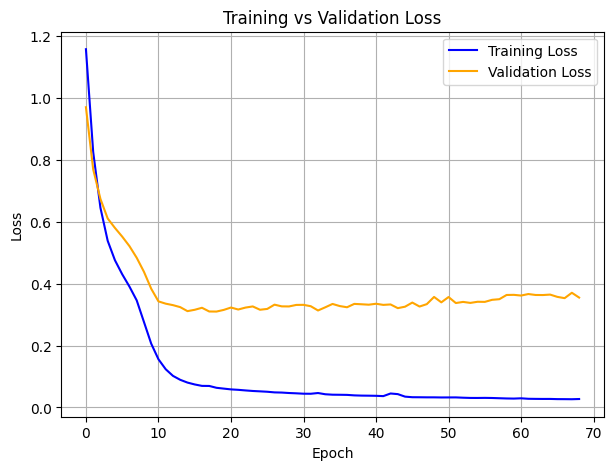

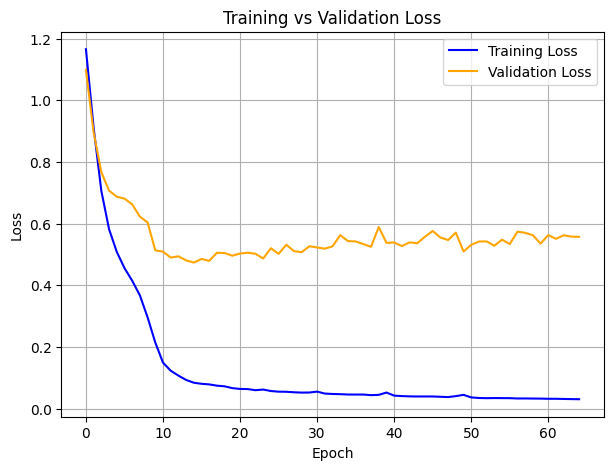

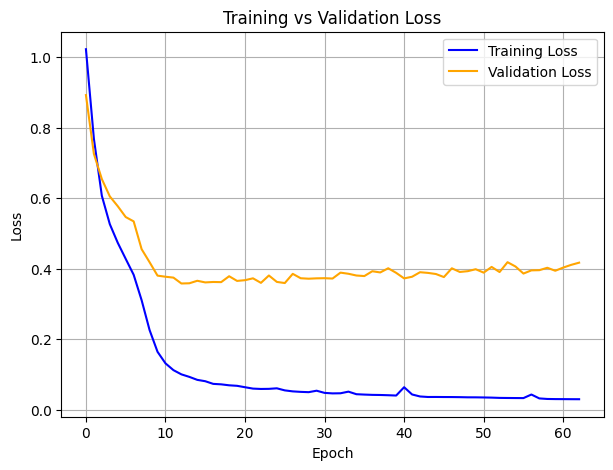

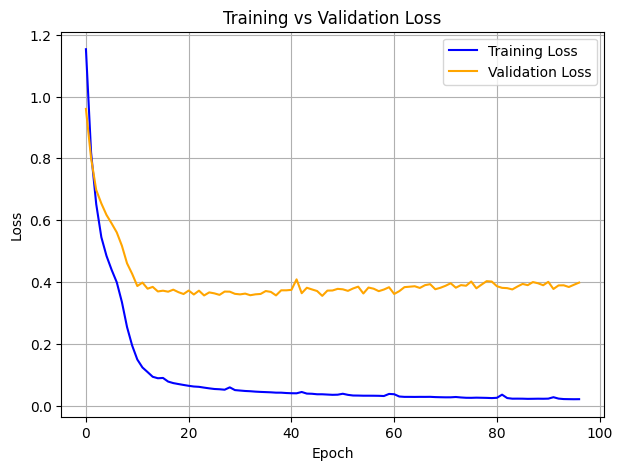

In [20]:
## Execution
from dataArrange import dataRearrange1
## Test Learn_EA without annealing
# training transformations and augmentations

transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')


y = [label_group[:2] for label_group in y_file_names]

X = np.array(X)
y = np.array(y)

print(X)
print(y)


if CROSS_VAL:
    skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
    # each case same division
    #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # if fold != 4:
        #      continue
        # Split the data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Split the training data further into train and validation ( 1/3 split)
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        
        input_train = X_train_final
        input_name_val = X_val
        print("Cross validation: " + str(CROSS_VAL))
        print(f"Fold: {fold} out of {N_SPLIT}")
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
        
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        
        #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
         
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold)
        mConv_predict(X_test, fold)
        
        # Force garbage collection
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    
    X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Cross validation: " + str(CROSS_VAL))
    print("Augmentation: " + str(AUGMENTED))
    if AUGMENTED:
        print("Augmentation amount: " + str(AUGMENTATION))
    print("Training: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
        
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print()
    
    if AUGMENTED:
        ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
        ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
        repeated_items_train = np.repeat(input_train, AUGMENTATION)
        suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
        input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
        
        #Custom Arranging for training dataset because of the augmentation order
        input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
        repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
        suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
        input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
    
    
    
    # # ### lastly added for weig
    # ht management
    # weights = weights.view(1, 1, 1, -1)  # Reshape for broadcasting
    
    # #making pytorch tensor
    # input_dataset = torch.tensor(input_dataset, dtype=torch.float32)
    # input_dataset_val = torch.tensor(input_dataset_val, dtype=torch.float32)
    # weights = torch.tensor(weights, dtype=torch.float32)
    
    # input_dataset = input_dataset * weights
    # input_dataset_val = input_dataset_val * weights
    # input_dataset = input_dataset.numpy()
    # input_dataset_val = input_dataset_val.numpy()
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0)
    mConv_predict(X_test)
    
    # Force garbage collection
    gc.collect()

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    

In [21]:
# df_optuna = pd.DataFrame(columns = ['Dice_importance', 'CE_importance', "Dice"])
# def objective(trial):
#     N_BLOCK = 5
#     LR = 0.003
                                                                                                        
#     OUTPUT_DIR = '20250528-DiCELossOptimization'
    
#     print(f"Trial {trial.number}")

#     IN_CHANNEL = 108

#     AUGMENTED = False
#     AUGMENTATION  =  30


#     CROSS_VAL = False
#     N_SPLIT = 4
    
#     DICE_IMPORTANCE = trial.suggest_float("dice_importance", 1.0, 100.0)
#     CE_IMPORTANCE = trial.suggest_float("ce_importance", 1.0, 100.0)
       
    
#     dice_val = executeExperiment()
    
#     #df_optuna.add([DICE_IMPORTANCE, CE_IMPORTANCE, dice_val])
#     return dice_val
    
# import optuna

# # Create a study to minimize or maximize the metric
# study = optuna.create_study(direction='maximize')  # or 'minimize' based on your metric
# study.optimize(objective, n_trials = 360)
# #df_optuna.to_csv("optuna_optimization_loss_function.csv") 
    
    


In [22]:

# print(study.best_params)
# study.best_value